# Sentiment Analysis Project (BYOND): Model Training

## Import Libraries

In [29]:
!pip install google-play-scraper

from google_play_scraper import app, reviews, Sort, reviews_all

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
SEED = 100
np.random.seed(SEED)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

import csv
import requests
from io import StringIO

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Wrangling

In [30]:
# Load the dataset

df = pd.read_csv('review_BYOND.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,f79d9b09-1cac-4f5e-8cc0-1fc783acd8cf,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat membantu saya dalam melakukan top up e-...,1,0,1.0.5,2025-04-19 23:26:55,"Assalamualaikum Kak, terima kasih atas keperca...",2025-04-19 23:27:13,1.0.5
1,838548bb-d403-47bd-a319-ab3c851b738b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,perbaiki aplikasi bsi merchant mu pak. bikin b...,1,0,1.0.5,2025-04-19 20:41:31,"Assalamualaikum Bapak Imam, mohon maaf atas ke...",2025-04-20 01:13:31,1.0.5
2,ba660a31-f350-40bf-b2c5-588e85ca2338,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi lemot login gak bisa,1,0,1.0.5,2025-04-19 20:00:00,"Assalamualaikum Bapak Fahri, mohon maaf atas k...",2025-04-20 01:11:51,1.0.5
3,f67d312e-0e84-49f8-a2a7-cee938695efd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi yg sangat berguna,5,0,NaN,2025-04-19 19:25:38,"Assalamualaikum Bapak Sudarjat, terima kasih a...",2025-04-20 01:14:57,NaN
4,916c765e-8b96-477a-81c2-45659ec12bed,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sering erol,1,0,1.0.5,2025-04-19 18:44:33,"Assalamualaikum Bapak Ibnu, mohon maaf atas ke...",2025-04-20 01:09:22,1.0.5


In [31]:
# dataset info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29394 entries, 0 to 29393
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              29394 non-null  object
 1   userName              29394 non-null  object
 2   userImage             29394 non-null  object
 3   content               29394 non-null  object
 4   score                 29394 non-null  int64 
 5   thumbsUpCount         29394 non-null  int64 
 6   reviewCreatedVersion  25354 non-null  object
 7   at                    29394 non-null  object
 8   replyContent          29254 non-null  object
 9   repliedAt             29254 non-null  object
 10  appVersion            25354 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


In [32]:
# Pick all the reviews

df_new = df[['content']]

In [33]:
# Functions for data preprocessing

# Remove marks, number, special characters
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

# Lowercase function
def casefoldingText(text):
    text = text.lower()
    return text

# Text tokenization
def tokenizingText(text):
    text = word_tokenize(text)
    return text

# Stopwords function
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# Stemming function
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

# Sentence function
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [34]:
# Change slang words with formal words

slang_df = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/refs/heads/master/colloquial-indonesian-lexicon.csv")
slang_df['slang'] = pd.concat([slang_df['slang'], pd.Series(['erol'])], ignore_index=True)
slang_df['formal'] = pd.concat([slang_df['formal'], pd.Series(['eror'])], ignore_index=True)
slang_df.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


In [35]:
slangwords = slang_df['slang']
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [36]:
# Apply all of the functions before

df_new['text_clean'] = df_new['content'].apply(cleaningText)
df_new['text_casefoldingText'] = df_new['text_clean'].apply(casefoldingText)
df_new['text_slangwords'] = df_new['text_casefoldingText'].apply(fix_slangwords)
df_new['text_tokenizingText'] = df_new['text_slangwords'].apply(tokenizingText)
df_new['text_stopword'] = df_new['text_tokenizingText'].apply(filteringText)
df_new['text_akhir'] = df_new['text_stopword'].apply(toSentence)

df_new.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Sangat membantu saya dalam melakukan top up e-...,Sangat membantu saya dalam melakukan top up ew...,sangat membantu saya dalam melakukan top up ew...,sangat membantu saya dalam melakukan top up ew...,"[sangat, membantu, saya, dalam, melakukan, top...","[membantu, top, ewallet, pembayaran, ecommerce...",membantu top ewallet pembayaran ecommerce pros...
1,perbaiki aplikasi bsi merchant mu pak. bikin b...,perbaiki aplikasi bsi merchant mu pak bikin bi...,perbaiki aplikasi bsi merchant mu pak bikin bi...,perbaiki aplikasi bsi merchant mu pak bikin bi...,"[perbaiki, aplikasi, bsi, merchant, mu, pak, b...","[perbaiki, aplikasi, bsi, merchant, mu, bikin,...",perbaiki aplikasi bsi merchant mu bikin bisnis...
2,aplikasi lemot login gak bisa,aplikasi lemot login gak bisa,aplikasi lemot login gak bisa,aplikasi lemot login gak bisa,"[aplikasi, lemot, login, gak, bisa]","[aplikasi, lemot, login]",aplikasi lemot login
3,aplikasi yg sangat berguna,aplikasi yg sangat berguna,aplikasi yg sangat berguna,aplikasi yg sangat berguna,"[aplikasi, yg, sangat, berguna]","[aplikasi, yg, berguna]",aplikasi yg berguna
4,sering erol,sering erol,sering erol,sering erol,"[sering, erol]",[erol],erol


### Skema 1
1. Ekstraksi fitur dengan TF-Idf.
2. Pembagian dataset dengan perbandingan 90:10.
3. Algoritma pelatihan menggunakan Deep Learning.


In [37]:
# Lexicon

lexicon_positive = dict()
lexicon_negative = dict()

response_positive = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
response_negative = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response_positive.status_code == 200:
    reader = csv.reader(StringIO(response_positive.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

else:
    print("Failed to fetch positive lexicon data")

if response_negative.status_code == 200:
    reader = csv.reader(StringIO(response_negative.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

else:
    print("Failed to fetch negative lexicon data")

In [38]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''

    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [39]:
# Polarity value counts

results = df_new['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_new['polarity_score'] = results[0]
df_new['polarity'] = results[1]
print(df_new['polarity'].value_counts())

polarity
negative    15411
positive    10362
neutral      3621
Name: count, dtype: int64


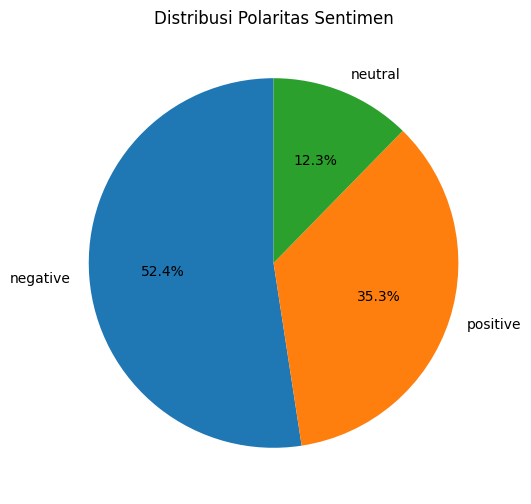

In [40]:
# Pie chart

polarity_counts = df_new['polarity'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Polaritas Sentimen')
plt.show()

In [41]:
df_new.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,Sangat membantu saya dalam melakukan top up e-...,Sangat membantu saya dalam melakukan top up ew...,sangat membantu saya dalam melakukan top up ew...,sangat membantu saya dalam melakukan top up ew...,"[sangat, membantu, saya, dalam, melakukan, top...","[membantu, top, ewallet, pembayaran, ecommerce...",membantu top ewallet pembayaran ecommerce pros...,15,positive
1,perbaiki aplikasi bsi merchant mu pak. bikin b...,perbaiki aplikasi bsi merchant mu pak bikin bi...,perbaiki aplikasi bsi merchant mu pak bikin bi...,perbaiki aplikasi bsi merchant mu pak bikin bi...,"[perbaiki, aplikasi, bsi, merchant, mu, pak, b...","[perbaiki, aplikasi, bsi, merchant, mu, bikin,...",perbaiki aplikasi bsi merchant mu bikin bisnis...,-11,negative
2,aplikasi lemot login gak bisa,aplikasi lemot login gak bisa,aplikasi lemot login gak bisa,aplikasi lemot login gak bisa,"[aplikasi, lemot, login, gak, bisa]","[aplikasi, lemot, login]",aplikasi lemot login,-9,negative
3,aplikasi yg sangat berguna,aplikasi yg sangat berguna,aplikasi yg sangat berguna,aplikasi yg sangat berguna,"[aplikasi, yg, sangat, berguna]","[aplikasi, yg, berguna]",aplikasi yg berguna,1,positive
4,sering erol,sering erol,sering erol,sering erol,"[sering, erol]",[erol],erol,0,neutral


In [14]:
X = df_new['text_akhir']
y = df_new['polarity']

def encoding_label(label):
    if label == 'positive':
        return 2
    elif label == 'neutral':
        return 1
    else:
        return 0

y = y.apply(encoding_label)

In [42]:
# Feature extraction with TF-Idf

tfidf = TfidfVectorizer(max_features=300, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

In [43]:
# Split teh dataset

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=SEED)

In [44]:
# Model 1

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 kelas
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


827/827 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7078 - loss: 0.6785 - val_accuracy: 0.8776 - val_loss: 0.3660
Epoch 2/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8580 - loss: 0.4118 - val_accuracy: 0.8810 - val_loss: 0.3567
Epoch 3/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8698 - loss: 0.3837 - val_accuracy: 0.8847 - val_loss: 0.3543
Epoch 4/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8735 - loss: 0.3773 - val_accuracy: 0.8837 - val_loss: 0.3479
Epoch 5/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8825 - loss: 0.3595 - val_accuracy: 0.8850 - val_loss: 0.3508
Epoch 6/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8840 - loss: 0.3508 - val_accuracy: 0.8861 - val_loss: 0.3534
Epoch 7/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8858 - loss: 0.3399 - val_accuracy: 0.8827 - val_loss: 0.3556
Epoch 8/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8911 - loss: 0.3364 - val_accuracy: 0.8830 - va

### Skema 2
1. Ekstraksi fitur dengan TF-Idf.
2. Pembagian dataset dengan perbandingan 80:20.
3. Algoritma pelatihan menggunakan Logistic Regression.


In [45]:
# Split teh datasets

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tfidf, y, test_size=0.2, random_state=SEED)

In [46]:
# Tuning

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()

param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)
grid_search.fit(X_train_2, y_train_2)
print(grid_search.best_params_)

{'C': 10, 'solver': 'lbfgs'}


In [47]:
# Model 2

logistic_regression = LogisticRegression(C=10, solver='lbfgs')
logistic_regression.fit(X_train_2.toarray(), y_train_2)

y_pred_train_lr = logistic_regression.predict(X_train_2.toarray())
y_pred_test_lr = logistic_regression.predict(X_test_2.toarray())

accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train_2)

accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test_2)

print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.8833935785668722
Logistic Regression - accuracy_test: 0.8746385439700629


### Skema 3
1. Ekstraksi fitur dengan Word2Vec.
2. Pembagian dataset dengan perbandingan 80:20.
3. Algoritma pelatihan menggunakan Deep Learning.


In [21]:
!pip install scipy==1.10.1

In [48]:
# Feature Extraction with Word2Vec

import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

df_new['tokens'] = df_new['text_akhir'].apply(lambda x: word_tokenize(x.lower()))

model_w2v = Word2Vec(sentences=df_new['tokens'], vector_size=100, window=5, min_count=2, workers=4)

def document_vector(doc):
    vectors = [model_w2v.wv[word] for word in doc if word in model_w2v.wv]
    if len(vectors) == 0:
        return np.zeros(model_w2v.vector_size)
    return np.mean(vectors, axis=0)

X_2 = np.array([document_vector(tokens) for tokens in df_new['tokens']])

In [49]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_2, y, test_size=0.2, random_state=SEED)

In [50]:
# Model 3

import tensorflow as tf

model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_3.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')  # 3 kelas
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model3.fit(X_train_3, y_train_3, epochs=20, validation_data=(X_test_3, y_test_3))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


735/735 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5920 - loss: 0.9863 - val_accuracy: 0.6789 - val_loss: 0.7844
Epoch 2/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6783 - loss: 0.8026 - val_accuracy: 0.6940 - val_loss: 0.7529
Epoch 3/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6894 - loss: 0.7732 - val_accuracy: 0.7079 - val_loss: 0.7173
Epoch 4/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7021 - loss: 0.7420 - val_accuracy: 0.7011 - val_loss: 0.7096
Epoch 5/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7032 - loss: 0.7295 - val_accuracy: 0.7200 - val_loss: 0.6922
Epoch 6/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7131 - loss: 0.7095 - val_accuracy: 0.7168 - val_loss: 0.6822
Epoch 7/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7155 - loss: 0.7040 - val_accuracy: 0.7233 - val_loss: 0.6655
Epoch 8/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7173 - loss: 0.6974 - val_accuracy: 0.7217 - val_

In [28]:
!pip freeze

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.14.0.37.22
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confe